# Определение возраста покупателей

## Исследовательский анализ данных

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

In [14]:

labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [15]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


1. Всего 7591 фотография.
2. Пропусков тоже нет.

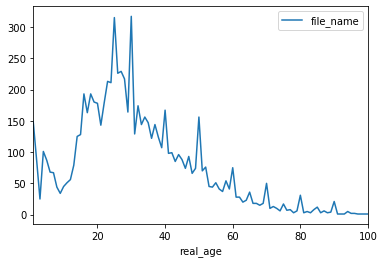

In [16]:
data_plot = labels.groupby('real_age').count()

data_plot.plot()

1. Распределение возраста похоже на нормальное, но смещено в лево.
2. В целом данный график похож на демографическую пирамиду, где наибольшее число людей трудоспособного возраста от 20 до 40 и дальнейший спад с увеличением возраста. Если смотреть в таком ключе, то пиковые показатели можно объяснить разной рождаемостью в разные года из-зи которого людей различного возраста больше, чем в других, как в начале графика, условно сейчас родильс больше, чем это значение дальше от нуля, поэтому есть пик на нуле.

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)
 
features, target = next(train_gen_flow)
print(features.shape, target.shape) 

Found 7591 validated image filenames.
(32, 224, 224, 3) (32,)


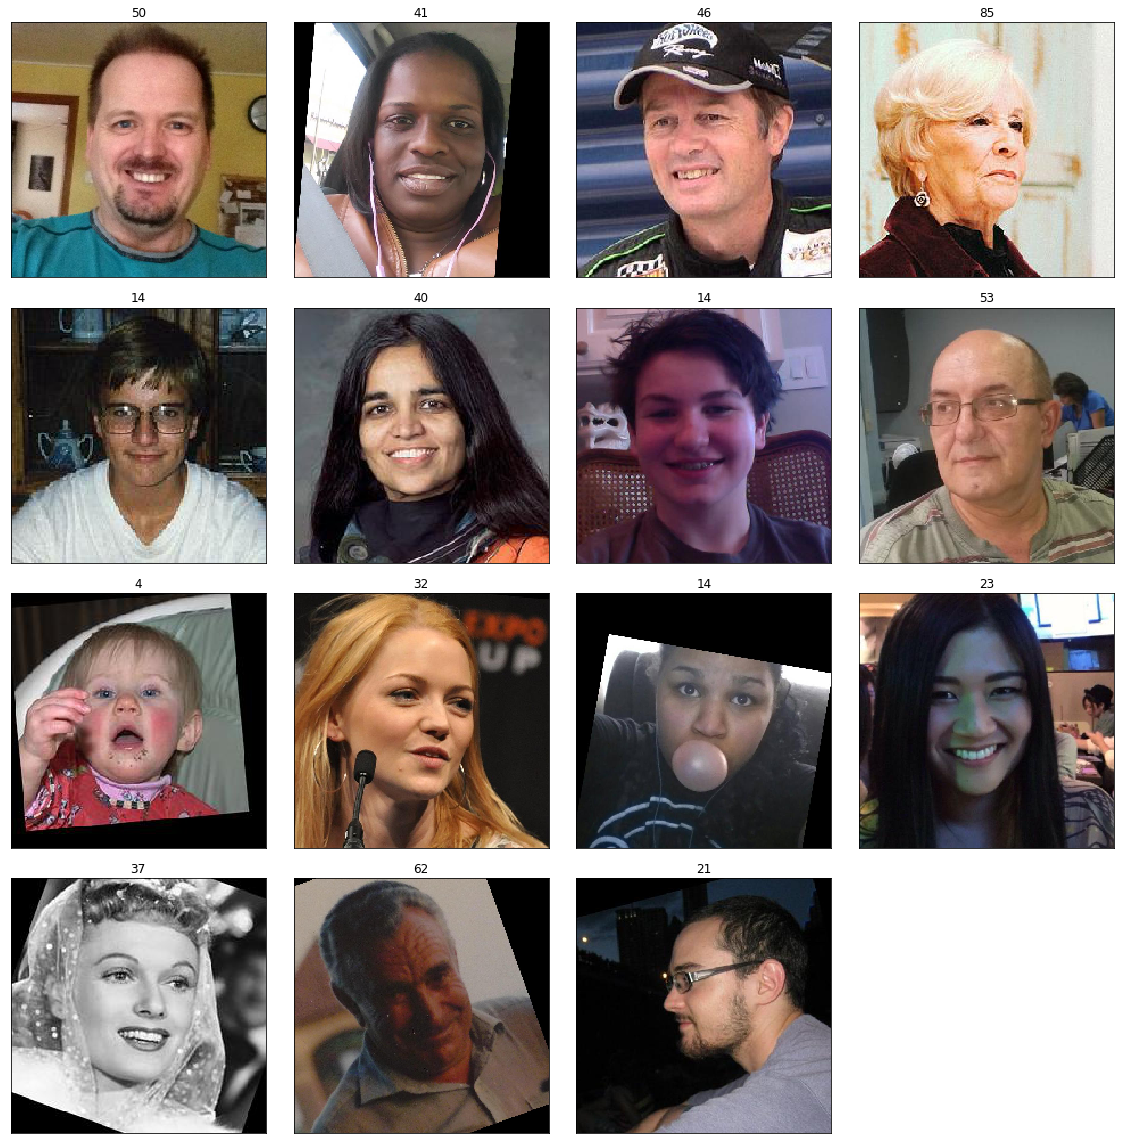

In [38]:
# выводим изображений
fig = plt.figure(figsize=(16,16))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

1. Фотографии представлены раздичного формата:
        1.1 Черно-белые
        1.2 Со смещение от центра и под углом относительно центра
        1.3 Фотографии разного качества, какие то хорошии, какие то довольно низкого
        1.4 Есть фотографии с замазаным фоном

## Код


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    train_data = train_gen_flow

    return train_data

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    test_data = test_gen_flow

    return test_data

def create_model(input_shape):
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, epochs=20, steps_per_epoch=None, validation_steps=None, batch_size=16):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
     
    
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-08-08 14:33:49.011001: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-08-08 14:33:53.111825: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 106s - loss: 185.8714 - mae: 10.2266 - val_loss: 298.1215 - val_mae: 12.8714
Epoch 2/20
356/356 - 37s - loss: 97.5991 - mae: 7.4891 - val_loss: 224.8931 - val_mae: 11.1195
Epoch 3/20
356/356 - 37s - loss: 61.3082 - mae: 6.0082 - val_loss: 111.6541 - val_mae: 8.0075
Epoch 4/20
356/356 - 37s - loss: 39.5921 - mae: 4.8863 - val_loss: 96.9169 - val_mae: 7.7285
Epoch 5/20
356/356 - 37s - loss: 25.8969 - mae: 3.9031 - val_loss: 97.5893 - val_mae: 7.7087
Epoch 6/20
356/356 - 37s - loss: 19.1602 - mae: 3.3589 - val_loss: 82.8893 - val_mae: 6.7701
Epoch 7/20
356/356 - 37s - loss: 18.3619 - mae: 3.2857 - val_loss: 78.3501 - val_mae: 6.6247
Epoch 8/20
356/356 - 37s - loss: 16.0941 - mae: 3.0658 - val_loss: 73.2791 - val_mae: 6.5833
Epoch 9/20
356/356 - 37s - loss: 15.0707 - mae: 2.9885 - val_loss: 86.1487 - val_mae: 6.9326
Epoch 10/20
356/356 - 37s - loss: 15.7690 - mae: 3.0413 - val_loss: 86.6368 - val_mae: 6.9343
Epoch 11/20
356/356 - 37s - loss: 13.8753 - mae: 2.8327 - val_loss: 85.1187 - val_mae: 6.9156
Epoch 12/20
356/356 - 37s - loss: 12.5403 - mae: 2.7191 - val_loss: 78.5237 - val_mae: 6.5093
Epoch 13/20
356/356 - 37s - loss: 11.9888 - mae: 2.6241 - val_loss: 108.0192 - val_mae: 7.4671
Epoch 14/20
356/356 - 37s - loss: 12.4170 - mae: 2.7008 - val_loss: 91.6560 - val_mae: 7.1223
Epoch 15/20
356/356 - 37s - loss: 11.6089 - mae: 2.5895 - val_loss: 76.3835 - val_mae: 6.4981
Epoch 16/20
356/356 - 37s - loss: 11.2875 - mae: 2.5514 - val_loss: 83.4828 - val_mae: 7.0999
Epoch 17/20
356/356 - 37s - loss: 11.1716 - mae: 2.5404 - val_loss: 85.0202 - val_mae: 6.8230
Epoch 18/20
356/356 - 37s - loss: 10.1331 - mae: 2.4102 - val_loss: 77.2061 - val_mae: 6.5278
Epoch 19/20
356/356 - 37s - loss: 8.6888 - mae: 2.2409 - val_loss: 69.7815 - val_mae: 6.2172
Epoch 20/20
356/356 - 37s - loss: 9.0628 - mae: 2.2901 - val_loss: 71.0042 - val_mae: 6.2988
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 71.0042 - mae: 6.2988
Test MAE: 6.2988
```

Я добавил горизонтальный флип и метрика меньше стала, решил убрать обратно.

## Анализ обученной модели

Для выполнения задачи определения возраста была использована 50-слойная ResNet с операцией глобальной максимальной подвыборки.
на выходе 1 нейрон, т.к. нам нужно предсказывать сам возраст. В качестве оптимизатора используется Adam. Он сочетает в себе и идею накопления движения и идею более слабого обновления весов для типичных признаков.
Несмотря на небольшую выборку были достигнуты неплохие значения метрики МАЕ.

Для бизнеса такое можеть полезным для построения данных о половозрастной структуре их клиентов, к примеру.

- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы